<a href="https://colab.research.google.com/github/Walidcorloene/TP_analyse_tweets/blob/main/TP_analyse_tweets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **TP Cours Textmining** 
#### *Etude portée sur les tweets deux politiques français*

*11-02-2022*

Les objectifs de ce TP sont : 
- Travailler sur du texte français
- Analyser les données 
- Reprendre les acquis développés dans les TP précédents
- Découvrir de nouveaux outils : scattertext
- Prédire qui a posté un tweet 


## **1. Installation des packages**

In [ ]:
!pip install scattertext
!pip install spacy
!pip install nltk

     |████████████████████████████████| 7.3 MB 5.9 MB/s 
     |████████████████████████████████| 24.1 MB 53.1 MB/s 
  Created wheel for flashtext: filename=flashtext-2.7-py2.py3-none-any.whl size=9309 sha256=a54293f03aa59b57783fb088f6d260f731559b79484aacc30d4543f5eb808704
  Stored in directory: /root/.cache/pip/wheels/cb/19/58/4e8fdd0009a7f89dbce3c18fff2e0d0fa201d5cdfd16f113b7
Successfully built flashtext
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


In [ ]:
!python -m spacy download fr_core_news_md

     |████████████████████████████████| 88.6 MB 16.6 MB/s 
  Created wheel for fr-core-news-md: filename=fr_core_news_md-2.2.5-py3-none-any.whl size=90338488 sha256=e0b721a6f636ff5502ec0fbb3f29160cd434385b7f02a4256e1435db3a81b4c1
  Stored in directory: /tmp/pip-ephem-wheel-cache-pd89hjf9/wheels/2e/26/ff/ce93eb966e7176ebe81e6c98209582e13e108cdd2d6d636df0
Successfully built fr-core-news-md
✔ Download and installation successful
You can now load the model via spacy.load('fr_core_news_md')


In [ ]:
import os
from google.colab import drive
drive.mount('drive/')

Mounted at drive/


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time
import datetime


# Modules de traitement du texte
import spacy
import fr_core_news_md
import nltk
import re
from termcolor import colored

# Modules pour le wordcloud
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# Module pour scattertext
import scattertext as st

# Modules de modélisation
from sklearn.utils.fixes import loguniform
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report


In [ ]:
# chemin où se trouve le jeu de données (tweets_politics_2022.csv)
os.chdir('drive/My Drive/NLP/Tweets/Data')

## **2. Prise en main de la base de données**

Les données ont été extraites via l'API tweepy dans un autre notebook. \
Les tweets de certains candidats à l'élection présidentiels ont été récupérés. 

Regardez les variables à disposition, quelques comptages, s'il y a des données manquantes, quelques graphiques (?), la spécificité des tweets, etc. 

#### Import des données

In [ ]:
df_tweets = pd.read_csv('tweets_politics_2022.csv', encoding="utf-8")

# ou si le csv est directement dans votre jupyter : 
# df_tweets = pd.read_csv('tweets_politics_2022.csv')

In [ ]:
df_tweets.shape

(18430, 6)

In [ ]:
df_tweets.head()

,id,created_at,favorite_count,retweet_count,text,user_id
0,1487771447992926210,2022-01-30 12:55:29,436.0,193.0,Redonner du sens à la gauche : se rassembler a...,JeanLuc_Melenchon
1,1487400906517848070,2022-01-29 12:23:05,2350.0,1027.0,L’inscription sur les listes électorales c’est...,JeanLuc_Melenchon
2,1487117751084855300,2022-01-28 17:37:55,1145.0,480.0,🔴 Rendez-vous ce dimanche 30 janvier à 20h55 s...,JeanLuc_Melenchon
3,1487104482336989191,2022-01-28 16:45:12,1164.0,437.0,3 solutions pour financer la retraite à 60 ans...,JeanLuc_Melenchon
4,1487080530558476288,2022-01-28 15:10:01,1591.0,551.0,La Méditerranée est le plus grand cimetière du...,JeanLuc_Melenchon


####  Quelques comptages / graphiques

##### Indicateurs simples sur les variables : 
- Y a't'il des données manquantes ? 
- combien de tweets de chaque candidat ? 
- dates minimales / maximales des tweets
- Distribution des favoris et des retweets de chaque candidat

<details>    
<summary>
    <font size="3" color="darkgreen"><b>Aide</b></font>
</summary>
<p>
<ul>
    <li> Utiliser .isnull() </li>
    <li><a href="https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.value_counts.html" >pd.value_counts()</a> pour compter le nombre de modalités d'une variable catégorielle </li>
    <li> Convertir la date au bon format avec pd.to_datetime() </li>
    <li> Vous pouvez utiliser la fonction groupby et describe() </li>

</ul>
</p>

In [ ]:
# Implémentez la fonction en changeant le None
def check_missing_values(df):
  print("check for missing values : ")
  print(df.isnull().sum()/len(df))  
  return None

check_missing_values(df_tweets)
# Vous pouvez également utiliser df.info()

check for missing values : 
id                0.0
created_at        0.0
favorite_count    0.0
retweet_count     0.0
text              0.0
user_id           0.0
dtype: float64


In [ ]:
# Combien de tweets dans la base de données pour chacun des 2 politiques ? 
df_tweets["user_id"].value_counts()
# ou df_tweets["user_id"].value_counts(normalize=True) si vous voulez avoir les pourcentages

Emmanuel_Macron        2969
Marine_Lepen           2782
JeanLuc_Melenchon      2756
Eric_Zemmour           2752
Christianne_Taubira    2402
Valerie_Pecresse       2399
Yannick_Jadot          1532
Anne_Hidalgo            838
Name: user_id, dtype: int64

In [ ]:
# A quelles dates ont été envoyés les premiers / derniers tweets de chaque candidat ? 
df_tweets["created_at"] = pd.to_datetime(df_tweets['created_at'])
df_tweets.groupby(["user_id"])["created_at"].apply(lambda x  : [x.min(), x.max()])

user_id
Anne_Hidalgo           [2021-07-12 15:29:23, 2022-01-30 10:58:47]
Christianne_Taubira    [2011-08-26 04:30:30, 2022-01-30 14:00:01]
Emmanuel_Macron        [2018-11-29 12:22:40, 2022-01-29 19:49:37]
Eric_Zemmour           [2020-12-18 22:18:49, 2022-01-29 21:58:31]
JeanLuc_Melenchon      [2021-09-13 08:57:51, 2022-01-30 12:55:29]
Marine_Lepen           [2020-02-10 21:38:13, 2022-01-30 12:17:02]
Valerie_Pecresse       [2018-06-20 09:40:14, 2022-01-29 17:54:29]
Yannick_Jadot          [2021-02-14 11:24:25, 2022-01-29 21:51:04]
Name: created_at, dtype: object

In [ ]:
# Quelle est la distribution des favoris de chaque candidat ?
df_tweets.groupby(["user_id"])[["favorite_count"]].describe()

favorite_count               ...                   
                             count         mean  ...      75%       max
user_id                                          ...                   
Anne_Hidalgo                 838.0   386.239857  ...   334.00   47058.0
Christianne_Taubira         2402.0   246.313489  ...   145.00   39010.0
Emmanuel_Macron             2969.0  6078.357696  ...  5756.00  204235.0
Eric_Zemmour                2752.0  3376.126090  ...  4229.75   34664.0
JeanLuc_Melenchon           2756.0   557.383527  ...   558.25   21247.0
Marine_Lepen                2782.0  1273.794033  ...  1573.75   14474.0
Valerie_Pecresse            2399.0   299.619842  ...   350.50    7622.0
Yannick_Jadot               1532.0   154.718016  ...   199.25    2778.0

[8 rows x 8 columns]

In [ ]:

# Quelle est la distribution des retweets de chaque candidat ?
df_tweets.groupby(["user_id"])[["retweet_count"]].describe()

retweet_count               ...                  
                            count         mean  ...      75%      max
user_id                                         ...                  
Anne_Hidalgo                838.0    98.097852  ...   113.00   2900.0
Christianne_Taubira        2402.0   137.960866  ...   102.75  15718.0
Emmanuel_Macron            2969.0  1088.372853  ...   950.00  64283.0
Eric_Zemmour               2752.0   844.556686  ...  1040.00   8698.0
JeanLuc_Melenchon          2756.0   194.824746  ...   216.00   5719.0
Marine_Lepen               2782.0   432.787563  ...   531.00   4097.0
Valerie_Pecresse           2399.0    98.312213  ...   112.00   3611.0
Yannick_Jadot              1532.0    60.967363  ...    86.00   1090.0

[8 rows x 8 columns]

> On voit que les candidats Emmanuel Macron et Eric Zemmour sont très suivis sur les réseaux

##### Répartition du nombre de retweets / favoris dans le temps 

In [ ]:
def visualize_count_favorites(df, userID) : 
  
  ''' Cette fonction permet de visualiser le nombre de favoris et de retweets 
  sur toute la période pour un user_id donné '''

  df_temp = df.loc[df["user_id"] == userID]
  ylabels = ["favorite_count", "retweet_count"]

  print("Représentation des nombres de retweets et de favoris de chaque tweet de {} par date".format(userID))
  fig = plt.figure(figsize=(13,5))
  fig.subplots_adjust(hspace=0.01,wspace=0.01)

  n_row = len(ylabels)
  n_col = 1
  for count, ylabel in enumerate(ylabels):
      ax = fig.add_subplot(n_row, n_col, count + 1)
      ax.plot(df_temp["created_at"], df_temp[ylabel])
      ax.set_ylabel(ylabel)
  
  plt.show()

Représentation des nombres de retweets et de favoris de chaque tweet de JeanLuc_Melenchon par date


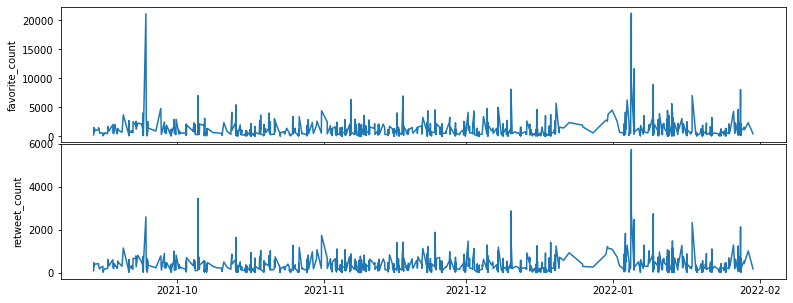



Représentation des nombres de retweets et de favoris de chaque tweet de Marine_Lepen par date


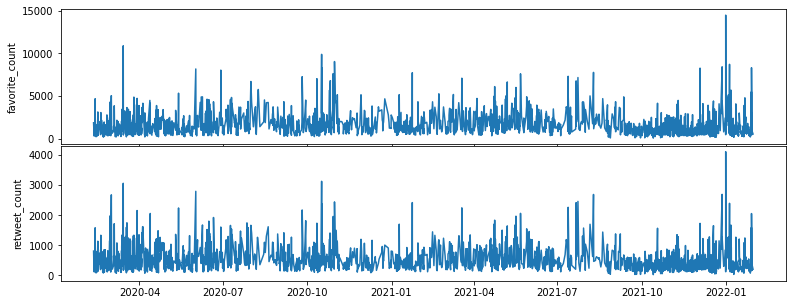

In [ ]:
visualize_count_favorites(df_tweets, "JeanLuc_Melenchon")
print("\n")
visualize_count_favorites(df_tweets, "Marine_Lepen")

> **Question** : Qu'observe-t'on ? 

**Réponse** : 
- JLM : 2 tweets ont été plus de 20K fois retweetés (alors qu'en moyenne, un tweet de JLM est retweeté 280 fois) et ont eu donc une grande popularité par rapport à son audience normale. 
- MLP a plutôt une audience stable, avec quelques tweets qui ont été plus retweetés (pic à 4K alors qu'en moyenne un tweet de MLP est retweeté 470 fois).

##### Taille des tweets par politique 

Est-ce que des candidats font des tweets + ou - longs que d'autres ? 

<details>    
<summary>
    <font size="3" color="darkgreen"><b>Aide</b></font>
</summary>
<p>
<ul>
    <li> Utilisez la fonction <a href="https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.str.split.html" >.split()</a> pour calculer la taille des tweets</li>
    <li> Vous pouvez utiliser la fonction groupby et describe() </li>

</ul>
</p>

In [ ]:
# Calcul d'une variable contenant le nombre de mots de chaque tweets
df_tweets["lenght_tweet"] = df_tweets["text"].apply(lambda tweet : len(tweet.split()))

# Calcul de la distribution de la variable pour chaque politique
df_tweets.groupby(["user_id"]).lenght_tweet.describe()

,count,mean,std,min,25%,50%,75%,max
user_id,,,,,,,,
Anne_Hidalgo,838.0,31.445107,13.764054,2.0,20.0,36.0,43.0,54.0
Christianne_Taubira,2402.0,19.308493,7.433403,1.0,15.0,19.0,22.0,52.0
Emmanuel_Macron,2969.0,29.939374,13.032758,1.0,20.0,32.0,41.0,57.0
Eric_Zemmour,2752.0,25.817951,12.788038,1.0,16.0,26.0,36.0,55.0
JeanLuc_Melenchon,2756.0,33.462264,10.601255,3.0,26.0,35.0,42.0,57.0
Marine_Lepen,2782.0,35.859094,10.283902,1.0,31.0,39.0,43.0,56.0
Valerie_Pecresse,2399.0,35.304710,10.299847,1.0,30.0,38.0,43.0,58.0
Yannick_Jadot,1532.0,30.542428,11.402907,1.0,23.0,33.0,39.0,55.0


**Réponse** : En moyenne : 
- Marine Lepen et Valérie Pécresse font des tweets plus longs que les autres. 
- Christianne Taubira et Eric Zemmour font des tweets plus courts que les autres.

##### Lecture de quelques tweets

In [ ]:
def print_famous_tweets(userID, nb_favorites) :

  ''' Cette fonction permet de sélectionner les tweets qui ont eu le plus de favoris 
  pour un user_id donné, et de lire le tweet avec les indicateurs des autres variables de la 
  base de données  
  '''

  df_sub = df_tweets.loc[(df_tweets.user_id==userID) & (df_tweets.favorite_count > nb_favorites),:]
  for irow in range(df_sub.shape[0]):
      df_row = df_sub.iloc[irow,:]
    
      print(df_row["created_at"])
      print("favorite_count={:6} retweet_count={:6}".format(df_row["favorite_count"],df_row["retweet_count"]))
      print(colored(df_row["text"], 'magenta'))
      print("\n")

In [ ]:
print_famous_tweets("JeanLuc_Melenchon", 20000)

2022-01-04 20:25:00
favorite_count=21247.0 retweet_count=5719.0
Le Président maîtrise-t-il ce qu'il dit ? 
L'OMS dit « convaincre plutôt que contraindre ». Et lui ? « Emmerder davantage». Consternant.

#Macron


2021-09-24 09:50:27
favorite_count=21142.0 retweet_count=2604.0
Hier, près de 100 000 personnes suivaient le #DebatBFMTV sur #Twitch sur les chaînes de @Sardoche_Lol, @HugoTravers et @DanyCaligula. Mais suite à une réclamation, ces comptes ont été ban 48h. Je le signale à Fogiel. Il faut que ça change pendant la campagne.




In [ ]:
print_famous_tweets("Marine_Lepen", 10000)

2021-12-31 16:43:49
favorite_count=14474.0 retweet_count=4097.0
Je suis outrée que le drapeau français ait été remplacé par celui de l’Union européenne sous l’Arc de Triomphe, au-dessus de la tombe du soldat inconnu. 

Cette provocation offense ceux qui se sont battus pour la France. Je demande à E. Macron de rétablir notre drapeau national. https://t.co/sR2IfjV3sG


2020-03-14 06:33:42
favorite_count=10881.0 retweet_count=3051.0
🇫🇷🇮🇹 Les Italiens, unis face à l’épidémie, se retrouvent à leurs balcons pour chanter leur hymne national. Très belles images de communion patriotique. 

Nous sommes de tout cœur avec vous ! ❤️ MLP https://t.co/XKBAtPY1K4




In [ ]:
print_famous_tweets("Eric_Zemmour", 20000)

2022-01-05 16:24:53
favorite_count=24894.0 retweet_count=8151.0
Pendant 5 ans, Emmanuel Macron a soigneusement refusé d'« emmerder » les racailles, les gangs, les apprentis-djihadistes, les immigrés hors-la-loi, les antifas et les idéologues qui lavent les cerveaux de nos enfants. Lâche avec les forts, cruel avec les faibles.


2022-01-04 22:53:13
favorite_count=24902.0 retweet_count=7461.0
Emmanuel Macron dit bel et bien : "J'ai envie d'emmerder". Ce n'est pas seulement la déclaration cynique d'un politicien qui veut exister dans la campagne présidentielle. C'est la cruauté avouée, assumée, qui parade devant des Français méprisés.


2021-11-30 11:29:07
favorite_count=34664.0 retweet_count=8698.0
Mes chers compatriotes, je suis candidat à l'élection présidentielle.




> **Question** : Qu'y-a't'il de particulier dans les tweets par rapport à un texte normal ?

**Réponse** : On voit que les tweets ont une syntaxe particulère : 
- hashtags 
- liens internet
- emojis

## **Filtres** 

Filtre sur la date pour ne garder que les tweets en début de campagne (septembre 2021)

In [ ]:
DATE_MIN = "2021-09-01 00:00:00"

df_tweets = df_tweets.loc[df_tweets["created_at"] >= datetime.datetime.strptime(DATE_MIN, "%Y-%m-%d %H:%M:%S")] 

print(f"Taille du dataframe : {len(df_tweets)}")

Taille du dataframe : 8749


Filtre sur certains candidats

In [ ]:
candidats_select = ["Eric_Zemmour", "Marine_Lepen", "JeanLuc_Melenchon", "Emmanuel_Macron"]

df_tweets = df_tweets.loc[df_tweets.user_id.isin(candidats_select)]
# copier les données
print(f"Taille du dataframe : {len(df_tweets)}")

Taille du dataframe : 6356


## **3. Preprocessing du texte**

On va prendre en compte les particularités des tweets pour nettoyer le texte. \
On va tester les techniques de preprocessing des cours précédents sur du texte français : 
- stopwords
- lemmatisation
- tokenisation


### Nettoyage du texte
Dans cette partie du TP, on nettoie le texte pour enlever les mots qui vont rajouter du bruit à l'analyse (et ne rien apporter) \
Pour nettoyer le texte : 
- suppression des chiffres
- suppression de certaines expressions grâce à des expressions régulières
- suppression des stopwords


In [ ]:
# on charge le modèle français de spacy
nlp = fr_core_news_md.load()
print(len(nlp.Defaults.stop_words))

# on peut rajouter des stopwords à la liste de spacy de cette manière : 
nlp.Defaults.stop_words |= {"avoir", "falloir", "faire", "monsieur", "direct",
                            "interview", "livetweet", "suivez", r"invité\w+", "chaîne", "youtube", "mlp"}

for word in nlp.Defaults.stop_words :
    for w in (word, word[0].capitalize(), word.upper()):
        lex = nlp.vocab[w]
        lex.is_stop = True

# nombre de stopwords 
len(nlp.Defaults.stop_words)

600


611

> **Conseil** :  Regarder toujours la liste entière de stopwords proposés pour enlever certains mots qui seraient utiles dans votre étude ou rajouter des stopwords non présents dans la liste

La cellule ci-dessous donne un exemple d'informations que peut donner Spacy : 

In [ ]:
doc = nlp(r"Demain je travaille \n\n à la maison. #fatigué @hetik \n https://test.com")

list_spacy = []
                
for token in doc : 
  list_spacy.append([token.text,
                        token.idx,
                        token.lemma_,
                        token.is_punct,
                        token.is_space,
                        token.is_alpha,
                        token.shape_,
                        token.pos_,
                        token.tag_,
                        token.ent_type_])
  
exemple_spacy = pd.DataFrame(list_spacy, columns=["text", "idx","lemma","is_punct","is_space","is_alpha","shape","pos","tag","ent_type"])
exemple_spacy

,text,idx,lemma,is_punct,is_space,is_alpha,shape,pos,tag,ent_type
0,Demain,0,demain,False,False,True,Xxxxx,ADV,ADV___,
1,je,7,je,False,False,True,xx,PRON,PRON__Number=Sing|Person=1,
2,travaille,10,travaille,False,False,True,xxxx,VERB,VERB__Mood=Ind|Number=Sing|Person=1|Tense=Pres...,
3,\n\n,20,\n\n,False,False,False,\x\x,ADJ,ADJ___,
4,à,25,à,False,False,True,x,ADP,ADP___,
5,la,27,le,False,False,True,xx,DET,DET__Definite=Def|Gender=Fem|Number=Sing|PronT...,
6,maison,30,maison,False,False,True,xxxx,NOUN,NOUN__Gender=Fem|Number=Sing,
7,.,36,.,True,False,False,.,PUNCT,PUNCT___,
8,#,38,#,True,False,False,#,NOUN,NOUN__Gender=Fem|Number=Sing,
9,fatigué,39,fatiguer,False,False,True,xxxx,VERB,VERB__Gender=Masc|Number=Sing|Tense=Past|VerbF...,


Expressions régulières pour nettoyer le texte 

In [ ]:
regexp_link = re.compile(r"http\S+") # suppression des liens
regexp_number = re.compile(r"\d+[h., ]?\d*") # suppression des chiffres

**TODO** : Créer une expression régulière pour supprimer les hashtags et @

<details>    
<summary>
    <font size="3" color="darkgreen"><b>Aide</b></font>
</summary>
<p>
Lorsque vous cherchez à créer des expressions régulières, vous pouvez vous aider en allant sur ce site : <a href="https://regex101.com/" >regex101.com</a> 
</p> 

In [ ]:
regexp_hashtags = re.compile(r"[#@]\w+")    # suppression des hashtags et @

In [ ]:
test_hashtags = "#Fuck ça #ne marche @pas !!"
re.sub(regexp_hashtags, "", test_hashtags)

' ça  marche  !!'

Création de la fonction de nettoyage du texte 

**TODO** : coder plusieurs fonctions :      
- une fonction `clean_text_spacy` qui prend en entrée un tweet et utilise spacy pour :     
    - supprimer les ponctuations ; 
    - supprimer les stopwords ; 
    - supprimer les caractères de type espace (\n, \t, etc.)
Cette fonction garde les tokens entiers
- une fonction `clean_lemmatize` :     
    - supprimer les ponctuations ; 
    - supprimer les stopwords ; 
    - supprimer les caractères de type espace (/n, /t, etc.)
Cette fonction garde non pas les tokens entiers, mais les lemmes. 
- une fonction chapeau `preprocess_tweet` qui : 
  - met les mots en minuscule
  - supprime les mots des expressions régulières
  - au choix applique la fonction `clean_text_spacy` ou `clean_lemmatize`

<details>    
<summary>
    <font size="3" color="darkgreen"><b>Aide</b></font>
</summary>
<p>
Lorsque vous utilisez les fonctions de spacy, vous allez potentiellement les tokeniser directement (et récupérer une liste au lieu d'un texte). Pour éviter cela, transformez le résultat de cette manière :    

```
result = " ".join(result)
```

</p> 

In [ ]:
def clean_txt_spacy(doc):

  clean_text = [token.text for token in doc if (not token.is_punct) and 
                                               (not token.is_stop) and 
                                               (token.pos_ != 'SPACE') ]
  clean_text = " ".join(clean_text)

  return clean_text


def lemmatize(doc):

  lemmatized_text = [token.lemma_ for token in doc if (not token.is_punct) and 
                                                      (not token.is_stop) and 
                                                      (token.pos_ != 'SPACE') ]
  lemmatized_text = " ".join(lemmatized_text)

  return lemmatized_text

In [ ]:
# J'ai rajouté cette fonction en plus, grâce à l'intervention d'un de vos camarades, si vous souhaitez supprimer les emojis dans votre texte
# Scattertext gère bien les emojis, mais dans votre modélisation, les emojis ne seront pas pris en compte. 
emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)

tweet_test = "Ils Pensaient se moquer #non, ils m'ont donné 1 slogan !😄 \n\n- Entretien à découvrir et partager \n\nhttps://t.co/Yn60Areagu"
print(emoji_pattern.sub(r'', tweet_test)) # no emoji

Ils Pensaient se moquer #non, ils m'ont donné 1 slogan ! 

- Entretien à découvrir et partager 

https://t.co/Yn60Areagu


In [ ]:
def preprocess_tweet(text, lemmatizing=True) : 

  '''Fonction permettant de nettoyer le texte. Elle renvoie un string (pas de tokenisation encore)'''
  #text_clean = emoji_pattern.sub(r'', text) si vous voulez supprimer les emojis dans votre nettoyage de texte, 
  # et décommentez cette ligne et changer text en text_clean dans la ligne en dessous
  text_clean = text.lower().encode('utf-8').decode('utf-8')
  text_clean = re.sub(regexp_link, "", text_clean)
  text_clean = re.sub(regexp_hashtags, "", text_clean)
  text_clean = re.sub(regexp_number, "", text_clean)

  # utilisation de spacy
  doc = nlp(text_clean)
  if lemmatizing :
    preprocessed_tweet = lemmatize(doc)
  else : 
    preprocessed_tweet = clean_txt_spacy(doc)

  return preprocessed_tweet 

In [ ]:
# exemple pour tester sa fonction
tweet_test = "Ils Pensaient se moquer #non, ils m'ont donné 1 slogan !😄 \n\n- Entretien à découvrir et partager \n\nhttps://t.co/Yn60Areagu"
preprocess_tweet(tweet_test, lemmatizing=True)

'pensaient moquer donner slogan 😄 entretien découvrir partager'


Réponse attendue : 
```python 
'pensaient moquer donner slogan 😄 entretien découvrir partager'
```

In [ ]:
# On peut alors nettoyer nos tweets, et créer une nouvelle colonne, text_preprocess
# cela peut prendre un peu de temps...  
df_tweets["text_preprocess"] = df_tweets["text"].apply(lambda tweet : preprocess_tweet(tweet, 
                                                                                       lemmatizing = True))

In [ ]:
# On regarde le résultat du nettoyage du texte
pd.set_option("max_colwidth", None)
df_tweets[["text", "text_preprocess"]].head(5)

,text,text_preprocess
0,Redonner du sens à la gauche : se rassembler avec le Parlement de l'Union Populaire - Tribune de membres du @ParlementPop. \n\nhttps://t.co/JzBPeFNSOz,redonner sens gauche rassembler parlement union populaire tribune membre
1,L’inscription sur les listes électorales c’est jusqu’au 4 mars et c’est le moyen de faire \n✅ la 6e République\n✅ le SMIC à 1400€ nets\n✅ la règle verte \n✅ la retraite à 60 ans\n✅ une France indépendante au service de la paix\n\n➡️ Ça se passe ici : https://t.co/FJUbiFzRFI https://t.co/orrqlIgQ42,inscription liste électoral jusqu’ mars moyen ✅ e république ✅ smic euro net ✅ règle vert ✅ retraite an ✅ france indépendant service paix ➡ ️ passer ici
2,🔴 Rendez-vous ce dimanche 30 janvier à 20h55 sur France 5 pour #cdanslair. https://t.co/Z7nsNC1rg4,🔴 rendre dimanche janvier france
3,3 solutions pour financer la retraite à 60 ans\n\n✅ Égalité salariale femmes-hommes\n✅ Augmenter les cotisations pour les salaires supérieurs à 3400€\n✅ Augmenter les cotisations patronales avec un fond de péréquation inter-entreprises pour que les grosses payent pour les petites https://t.co/WSCD1xX5Qt,solution financer retraite an ✅ égalité salarial femme homme ✅ augmenter cotisation salaire supérieur euro ✅ augmenter cotisation patronal fond péréquation inter-entrepriser gros payer petit
4,"La Méditerranée est le plus grand cimetière du monde. Ceux qui émigrent ne partent pas par plaisir. Il faut donc arrêter les accords commerciaux déséquilibrés. Mais quand les gens sont là, il ne faut pas les maltraiter. Il faut les traiter humainement et dignement.\n\n#FaceABaba https://t.co/K2VLIbH7dI",méditerranée grand cimetière monde émigrer partir plaisir falloir arrêter accord commercial déséquilibré falloir maltraiter falloir traiter humainement dignement



> Le preprocess n'est pas encore parfait, on pourrait enlever les verbes avec du pos-tagging, on pourrait rajouter le pos-tagging après chaque mot pour aider le modèle également. 

### Tokenisation
On tokenise la colonne de tweets prétraités (preprocess)

**TODO** : utiliser le module nltk pour tokeniser un tweet avec la fonction tokenisation

In [ ]:
nltk.download('punkt') # nécessaire pour la tokenisation

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
# Remplir le None dans le code
def tokenisation(tweet):
  tweet_tokenized = nltk.word_tokenize(tweet)
  return tweet_tokenized

In [ ]:
# On peut alors tokeniser nos tweets, et créer une nouvelle colonne, tokens
df_tweets["tokens"] = df_tweets["text_preprocess"].apply(lambda tweet : tokenisation(tweet))

In [ ]:
# On regarde le résultat de la tokenisation
df_tweets[["text_preprocess", "tokens"]].head()

,text_preprocess,tokens
0,redonner sens gauche rassembler parlement union populaire tribune membre,"[redonner, sens, gauche, rassembler, parlement, union, populaire, tribune, membre]"
1,inscription liste électoral jusqu’ mars moyen ✅ e république ✅ smic euro net ✅ règle vert ✅ retraite an ✅ france indépendant service paix ➡ ️ passer ici,"[inscription, liste, électoral, jusqu, ’, mars, moyen, ✅, e, république, ✅, smic, euro, net, ✅, règle, vert, ✅, retraite, an, ✅, france, indépendant, service, paix, ➡, ️, passer, ici]"
2,🔴 rendre dimanche janvier france,"[🔴, rendre, dimanche, janvier, france]"
3,solution financer retraite an ✅ égalité salarial femme homme ✅ augmenter cotisation salaire supérieur euro ✅ augmenter cotisation patronal fond péréquation inter-entrepriser gros payer petit,"[solution, financer, retraite, an, ✅, égalité, salarial, femme, homme, ✅, augmenter, cotisation, salaire, supérieur, euro, ✅, augmenter, cotisation, patronal, fond, péréquation, inter-entrepriser, gros, payer, petit]"
4,méditerranée grand cimetière monde émigrer partir plaisir falloir arrêter accord commercial déséquilibré falloir maltraiter falloir traiter humainement dignement,"[méditerranée, grand, cimetière, monde, émigrer, partir, plaisir, falloir, arrêter, accord, commercial, déséquilibré, falloir, maltraiter, falloir, traiter, humainement, dignement]"


### Analyse du preprocess

On regarde un peu les résultats du preprocessing : 
- combien y a-t-il de mots distincts pour chacun des deux hommes politiques ? 
- Quels sont les mots les plus utilisés par deux candidats de votre choix ? 

Pour cela vous vous aiderez des deux fonctions données ci-dessous

In [ ]:
def create_big_tweet_by_userid(userid, col_text) : 
  ''' Fonction pour mettre tous les tweets de chaque politiciens dans un même text (string) '''
  one_big_tweet = " ".join(df_tweets.loc[df_tweets["user_id"] == userid, col_text])
  return one_big_tweet

In [ ]:
def get_n_most_common_words(list_words, n) :
  ''' Fonction permettant de donner les n mots les plus fréquents d'une liste de mots '''
  freq_words = nltk.FreqDist(list_words)
  print(freq_words.most_common(n))

**TODO** : Si on n'utilise pas de preprocessing, quels sont les mots les plus utilisés par les 2 politiciens ?

In [ ]:
# Créer un gros tweet pour chacun des deux politiques (qui est la jointure de l'ensemble de ses tweets)
big_tweet_candidate1 = create_big_tweet_by_userid('Marine_Lepen', 'text')
big_tweet_candidate2 = create_big_tweet_by_userid('Emmanuel_Macron', 'text')

# Tokeniser le gros tweet de chacun des politiques
tokens_candidate1 = tokenisation(big_tweet_candidate1)
tokens_candidate2 = tokenisation(big_tweet_candidate2)

# Regarder les 10 mots les plus communs pour chacun des politiques
get_n_most_common_words(tokens_candidate1, 10)
get_n_most_common_words(tokens_candidate2, 10)

[('de', 2179), (',', 1916), ('.', 1663), (':', 1602), ('https', 1322), ('la', 1272), ('’', 1087), ('#', 1032), ('à', 920), ('et', 840)]
[('.', 999), (',', 963), ('de', 668), ('’', 502), ('la', 445), (':', 427), ('et', 310), ('https', 298), ('les', 248), ('à', 233)]


**Réponse** : les mots les plus utilisés sont des stopwords ou des ponctuations

Sans preprocessing, combien y a-t-il de mots distincts pour chaque politique ?

In [ ]:
# la fonction set appliquée sur une liste donne une liste d'éléments uniques
print("Nombre de mots distincts dans les tweets du candidat 1 : {}".format(len(set(tokens_candidate1))))
print("Nombre de mots distincts dans les tweets du candidat 2 : {}".format(len(set(tokens_candidate2))))

Nombre de mots distincts dans les tweets du candidat 1 : 8108
Nombre de mots distincts dans les tweets du candidat 2 : 4394


**Réponse** : 

Jean Luc Mélenchon : 11877 \
Eric Zemmour : 8960 \
Marine Lepen : 8108 \
Emmanuel Macron : 4394

**TODO** : même question avec un preprocessing ?


In [ ]:
# Créer un gros tweet pour chacun des deux politiques (qui est la jointure de l'ensemble de ses tweets)
big_tweet_candidate1 = create_big_tweet_by_userid('Marine_Lepen', 'text_preprocess')
big_tweet_candidate2 = create_big_tweet_by_userid('Emmanuel_Macron', 'text_preprocess')

# Tokeniser le gros tweet de chacun des politiques
tokens_candidate1 = tokenisation(big_tweet_candidate1)
tokens_candidate2 = tokenisation(big_tweet_candidate2)

# Regarder les 10 mots les plus communs pour chacun des politiques
get_n_most_common_words(tokens_candidate1, 10)
get_n_most_common_words(tokens_candidate2, 10)

[('français', 350), ('📹', 340), ('france', 229), ('🏻', 205), ('👉', 178), ('président', 158), ('pays', 124), ('vouloir', 123), ('🇫', 112), ('🇷', 112)]
[('france', 120), ('the', 75), ('européen', 59), ('to', 48), ('engager', 45), ('europe', 42), ('français', 42), ('an', 40), ('y', 40), ('être', 36)]


In [ ]:
print("Nombre de mots distincts dans les tweets du candidat 1 : {}".format(len(set(tokens_candidate1))))
print("Nombre de mots distincts dans les tweets du candidat 2 : {}".format(len(set(tokens_candidate2))))

Nombre de mots distincts dans les tweets du candidat 1 : 3997
Nombre de mots distincts dans les tweets du candidat 2 : 2761


**Réponse** : 

Jean Luc Mélenchon : 5369 \
Eric Zemmour : 4628

### Nuage de mots

On trace un nuage de mots pour chacun des politiques pour voir ce qui ressort

**#TODO** : Faire un nuage de mots pour deux candidats de votre choix avec 30 mots

In [ ]:
def create_wordcloud(text, nb_words):
  wordcloud = WordCloud(max_words=nb_words, background_color="white").generate(text)
  plt.figure()
  plt.imshow(wordcloud, interpolation="bilinear")
  plt.axis("off")
  plt.show()

Wordcloud des mots lemmatisés de l'ensemble des tweets de Jean-Luc Mélenchon


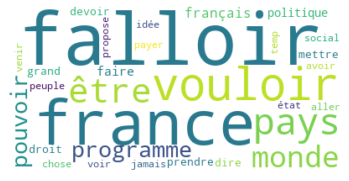

In [ ]:
lemat_candidat1 = " ".join(df_tweets.loc[df_tweets.user_id=="JeanLuc_Melenchon", "text_preprocess"])
print("Wordcloud des mots lemmatisés de l'ensemble des tweets de Jean-Luc Mélenchon")
create_wordcloud(lemat_candidat1, 30)

Wordcloud des mots lemmatisés de l'ensemble des tweets de Eric_Zemmour


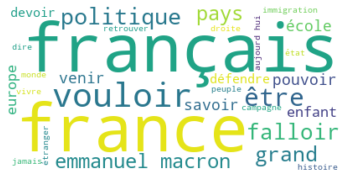

In [ ]:
lemat_candidat2 = " ".join(df_tweets.loc[df_tweets.user_id=="Eric_Zemmour", "text_preprocess"])
print("Wordcloud des mots lemmatisés de l'ensemble des tweets de Eric_Zemmour")
create_wordcloud(lemat_candidat2, 30)

C'est bien beau, mais c'est difficile à analyser, et surtout à comparer... \
On va utiliser scattertext pour comparer réellement le vocabulaire des 2 politiques.

## **4. Scattertext**

Grâce à Scattertext, on va pouvoir comparer de manière visuelle la distinction de vocabulaire utilisé par Jean-Luc Mélenchon et Eric Zemmour. 


On doit d'abord construire un corpus avec nos données : 
- donner la variable de catégorie 
- donner la variable du texte

On peut rajouter le partie ```.compact(st.AssociationCompactor(4000))``` pour ne prendre en compte que les 4000 mots les plus importants dans le scattertext.

**TODO** : créer le corpus avec la fonction donnée ci-dessous

In [ ]:
df_sample = df_tweets.loc[df_tweets.user_id.isin(["Eric_Zemmour", "JeanLuc_Melenchon"])]

# on crée un objet corpus pour scattertext
corpus = st.CorpusFromPandas(data_frame = df_sample,
                             category_col = "user_id",
                             text_col = "text_preprocess",
                             nlp = nlp).build().compact(st.AssociationCompactor(4000))

Une fois le corpus créé, on peut créer le html avec le scattertext.
 
On utilise la fonction ```st.produce_scattertext_explorer``` en donnant les paramètres vus pendant le cours : 
- term_ranker
- term_scorer
- transform 

**TODO** : remplir la fonction en réfléchissant aux paramètres que vous voulez tester.

In [ ]:
# On crée le html du scattertext
html = st.produce_scattertext_explorer(  corpus
                                       , category                  = 'Eric_Zemmour'
                                       , category_name             = 'Eric Zemmour'
                                       , not_category_name         = 'Jean Luc Melenchon'
                                       , minimum_term_frequency    = 10
                                       , pmi_threshold_coefficient = 1
                                       , term_ranker               = st.AbsoluteFrequencyRanker
                                       , transform                 = st.Scalers.dense_rank # #st.Scalers.log_scale_standardize pour le ScaledFscore
                                       , term_scorer               = st.RankDifference() 
#on peut égalemet tester le term_scorer ScaledFscore : st.ScaledFScorePresets(beta=1, one_to_neg_one=True)
                                       , width_in_pixels           = 1000
                                       )

# On enregistre le html
open("tweets_visualisation.html", 'wb').write(html.encode('utf-8'))

1174668

**TODO** : regarder le résultat (il apparaitra normalement dans le dossier content du notebook) en téléchargeant le html (cela peut prendre un petit moment avant de s'afficher correctement).

**Question** : On peut voir :
- les mots "stopwords" apparaitre en haut à droite : 
  - des verbes / des mots balises
  - des mots très utilisés dans le langage politique ("France", "politique", "peuple")
- En bas à droite, il y a les mots associés à Jean-Luc Mélenchon : 
  - "retraite", "programme", "populaire", "commun", "humain"
- En haut à gauche, il y a les mots associés à Eric Zemmour : 
  - "Emmanuel Macron", "enfant", "immigration", "étranger", "rural", "civilisation"

## **5. Modélisation**

On souhaite prédire si un tweet provient du compte de Marine Le Pen, de Jean Luc Mélenchon, d'Eric Zemmour ou d'Emmanuel Macron. Pour cela, on a besoin de : 
- Créer un échantillon train / dev
- préparer le text (preprocessing)
- créer des features (plusieurs méthodes : counts of words, tfidf ou autre)
- réaliser l'algorithme
- évaluer la performance du modèle 

### Création des échantillons 

**TODO** : créer un échantillon train (70% du jeu de données total) et un échantillon test 

<details>    
<summary>
    <font size="3" color="darkgreen"><b>Aide</b></font>
</summary>
<p>
<ul>
  <li> Utilisez la fonction <a href="https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html" >train_test_split</a></li>
  <li> Vous pouvez prendre tout le df_tweet dans le X</li>
  <li> N'oubliez pas de rajouter un random_seed pour avoir des résultats reproductibles</li>
</p> 

In [ ]:
df_train, df_test, y_train, y_test = train_test_split(df_tweets,
                                                    df_tweets["user_id"], 
                                                    test_size=0.3, 
                                                    random_state=123)

In [ ]:
print(f"Nombre de tweets dans l'échantillon train : {len(df_train)}")
print(f"Nombre de tweets dans l'échantillon test : {len(df_test)}")

In [ ]:
# on vérifie que la répartition entre les user 
print(y_train.value_counts(normalize=True))
print("\n")
print(y_test.value_counts(normalize=True))

On a la même répartition des candidats entre le train et le test. \
Les données ne sont pas équilibrées (Emmanuel Macron a peu de tweets). 

### Modèle de régression multinomiale sans gridsearch 

- Transformer le texte de X_train et X_test en vecteurs pour le modèle
- Utiliser la régression logistique multinomiale avec les paramètres par défaut
- Regarder les hyperparamètres par défaut sélectionnés
- Regarder le score sur l'échantillon test

**#TODO** : transformer X_train pour que ce ne soit plus des tweets, mais des vecteurs grâce à <a href="https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html" >TfidfVectorizer</a> (vous pouvez regarder les paramètres associés à la fonction)

<details>    
<summary>
    <font size="3" color="darkgreen"><b>Aide</b></font>
</summary>
<p>

La fonction TfidfVectorizer a des paramètres que vous pouvez choisir : 
<ul>

- Combien de n-grams : vous considérez mot par mot ou bien également des groupes de 2 mots
- max_df : si vous voulez enlever un pourcentage de mots les plus fréquents
- min_df : si vous voulez enlever un pourcentage de mots les moins fréquents
</p> 




In [ ]:
vectorizer = TfidfVectorizer(max_df=0.9, min_df=5, ngram_range=(1, 2))
X_train = vectorizer.fit_transform(df_train['text_preprocess'])

In [ ]:
# Si on veut regarder les mots présents dans le TFIDF (bigrams)
#sorted(vectorizer.vocabulary_.keys())[0:100]

# nombre de colonnes au tfidf 
len(vectorizer.vocabulary_)

In [ ]:
# vous pouvez tester avec ngram_range =(1,2) ou ngram_range=1, 
# pour voir le nombre de variables créées dans le X_train 
# (attention, faites retourner le train_test_split avant)
X_train.shape

**#TODO** : créer le modèle de régression logistique (OVR) et entrainer le modèle sur les données d'apprentissage

In [ ]:
# initialiser le modèle 
model = LogisticRegression(multi_class="ovr", random_state=54269)

# entrainer le modèle avec les données d'apprentissage
model_default_fit = model.fit(X_train, y_train)

NB : le random state permet de figer l'aléatoire, et de trouver toujours les mêmes résultats même en faisant tourner le modèle plusieurs fois. 

In [ ]:
# vous pouvez voir les paramètres du modèle 
model_default_fit.get_params(deep=True)

Attention, la régression logistique de scikit learn permet de faire des modèles plus complexes qu'une régression logistique normale que vous avez vu en cours : avec les paramètres "penalty", vous créer en fait un modèle de régression logistique pénalisé (ridge ou lasso). \
<a href="https://towardsdatascience.com/the-basics-logistic-regression-and-regularization-828b0d2d206c" >article sur régression logistique pénalisée</a> \
<a href="https://towardsdatascience.com/penalized-regression-with-classification-f60bc663e8dc" >autre article</a>




**#TODO** : Regarder la performance du modèle sur l'échantillon train et test (accuracy)

<details>    
<summary>
    <font size="3" color="darkgreen"><b>Aide</b></font>
</summary>
<p>
<ul>
  <li> N'oubliez pas de transformer le texte de l'échantillon test en vecteur en amont</li>
  <li> Vous pouvez utiliser la fonction <a href="https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html">score</a>  du modèle</li>
  
</p> 

In [ ]:
# Sur le train
model_default_fit.score(X_train, y_train) 
# Mon résultat est 0.84

In [ ]:
# Sur le test
X_test = vectorizer.transform(df_test['text_preprocess'])
model_default_fit.score(X_test, y_test) 
# Mon résultat est : 0.71

On voit que le modèle surappend sur l'échantillon train, et qu'il y a de grandes différences de performances entre train et test. 

**#TODO** : regarder plus en détail ce que donne le modèle : 

In [ ]:
print("le 1er tweet de l'échantillon test a été prédit : ")
print(model_default_fit.predict(X_test[0]))

In [ ]:
print(model_default_fit.classes_) # pour connaître l'ordre des classes / des modèles
model_default_fit.predict_proba(X_test[0])

**Question** : que retourne la ligne de code ci-dessus ?

**Réponse** : les résultats des 4 modèles de régression logistique que scikit learn a fait tourner (car on est en One VS rest). 

On voit donc que le 3e modèle qui prédit Jean Luc Mélenchon VS reste, donne la probabilité la plus élevée (0.56 dans mon cas). Scikit learn prédit donc que le 1er tweet vient du compte de Jean Luc Mélenchon

### Mise en place d'une random search

On veut mettre en place une randomsearch pour sélectionner les meilleurs hyperparamètres qu'on a choisi d'évaluer via la méthode de cross-validation : 
- on établit d'abord la grille de hyperparamètres que l'on veut tester
- on effectue la randomsearch
- on regarde les résultats sut l'échantillon test

In [ ]:
dict_params = dict(prep__text_preprocess__max_df=[0.99, 0.95, 0.9],
                   prep__text_preprocess__min_df=[2, 5, 10],
                   clf__C = [1,20,50],
                   clf__penalty = ['l2'],
                   clf__multi_class=['ovr', 'multinomial'])

**#TODO** : Entrainer la randomizedsearch avec les hyperparamètres ci-dessus sur les données d'apprentissage avec de la cross validation

NB : une pipeline a été mise en place dans la cellule ci-dessous afin de pouvoir tester également les paramètres du TFIDF. 


<details>    
<summary>
    <font size="3"**texte en gras** color="darkgreen"><b>Aide</b></font>
</summary>
<p>
<ul>
  <li> Vous pouvez utiliser la fonction <a href="https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html">RandomizedSearchCV</a></li>
  
</p> 

In [ ]:
# Vectorisation de la variable text_preprocess
text_transformer_tfidf =  TfidfVectorizer()
preprocess = ColumnTransformer([("text_preprocess", text_transformer_tfidf, "text_preprocess")], 
                               remainder="drop")

# Type de modèle à tester
model = LogisticRegression(random_state=54269, max_iter=1000)

# Pipeline qui combine le preprocess et le modèle
prep_model = Pipeline(steps=[('prep',preprocess),
                             ('clf', model)])

# RANDOMIZED SEARCH
random_search = RandomizedSearchCV( prep_model,
                                   dict_params,
                                   cv=5,  # cross validation de 5 échantillons
                                   n_iter=20,
                                   random_state=5439676,
                                   n_jobs=-1,
                                   verbose=1)

best_rd_model = random_search.fit(df_train, y_train)

In [ ]:
# Paramètres sélectionnés  :
# best_rd_model.cv_results_
best_rd_model.best_estimator_

Quelle accuracy le meilleur modèle a-t'il atteint sur l'échantillon train ? 

In [ ]:
best_rd_model.best_score_
# Mon résultat est 0.74

Le modèle avec les hyperparamètres sélectionnés par cross validation a une performance de 0.74 en cross validation et est un peu meilleur que le modèle par défaut.



**#TODO** : on évalue la performance en calculant l'accuracy du modèle de randomsearch sur l'échantillon test



In [ ]:
best_rd_model.score(df_test, y_test)
# Mon résultat est 0.75

Sur l'échantillon test, le modèle a une performance de 0.75, donc le modèle n'overfit pas.

### Evaluation de la performance du modèle 

On va calculer la matrice de confusion sur l'échantillon test

<details>    
<summary>
    <font size="3" color="darkgreen"><b>Aide</b></font>
</summary>
<p>
<ul>
  <li> Vous pouvez utiliser la fonction <a href="https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html" >ConfusionMatrixDisplay</a></li>
  
</p> 

In [ ]:
#matrice de confusion
#confrontation entre Y obs. sur l’éch. test et la prédiction
predictions = best_rd_model.predict(df_test)

cm = confusion_matrix(y_test, 
                      predictions, 
                      labels=best_rd_model.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=best_rd_model.classes_)
disp.plot(cmap=plt.cm.Blues,values_format='g',xticks_rotation='vertical')
plt.show()

**#TODO** : Interpréter les résultats 

**Question** : Sur l'ensemble des tweets de JLM, combien (pourcentage) ont bien été prédits JLM ?  

**Réponse** : 87% des tweets de JLM ont été prédits JLM par le modèle. 
``` 
728/(728+7+77+26) 
```

In [ ]:
#On peut aussi retrouver le résultat via cette fonction
print(classification_report(y_test, best_rd_model.predict(df_test)))

On voit que le recall (rappel) sur Emmanuel Macron est très faible (0.45) VS de bons recall pour Jean Luc Mélenchon ou Eric Zemmour. 

### Test sur des nouvelles données :

Ces quelques tweets ont été récupérés après que la base de données ait été récupérée. Ce sont donc des nouvelles données que le modèle n'a jamais vu.

**#TODO** : Qui a publié ces tweets ? 

In [ ]:
df_mystere = pd.read_excel(f"{PATH_DATA}/test_mystere.xlsx")
df_mystere["text"]

In [ ]:
df_mystere["text_preprocess"] = df_mystere.text.apply(lambda row : preprocess_tweet(row, lemmatizing=True))
df_mystere["tokens"] = df_mystere.text_preprocess.apply(lambda row : tokenisation(row))

best_rd_model.predict(df_mystere)

**Réponse attendue avec le modèle** :

```
array(['Eric_Zemmour', 'Eric_Zemmour', 'JeanLuc_Melenchon',
       'Emmanuel_Macron', 'JeanLuc_Melenchon'], dtype=object)
```

Les tweets sont en fait ceux de :     
- Marine Lepen ; 
- Eric Zemmour ; 
- Jean Luc Mélenchon ; 
- Emmanuel Macron ; 
- la reine des neiges ; 

Le modèle a confondu Marine Lepen avec Eric Zemmour.

Le vocabulaire employé dans les paroles de la reine des neiges a fait pencher le modèle plutôt vers Jean Luc Mélenchon 👸


TP réalisé par Manon Richard

📧 : manon.richard@group-consort.com